# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given cell contains a malaria parasite or not.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [6]:
cwd= os.getcwd()

In [7]:
os.chdir('/workspace/WalkthroughProject01')
print("You set a new current directory")

You set a new current directory


In [8]:

work_dir = os.getcwd()
work_dir

'/workspace/WalkthroughProject01'

---

## Set input directories

Set train, validation and test paths

In [9]:
my_data_dir = 'inputs/malaria_dataset/cell_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [10]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [11]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['Parasitized', 'Uninfected']


## Set image shape

In [12]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(129, 129, 3)

---

# Number of images in train, test and validation data

* train - Parasitized: 3950 images
* train - Uninfected: 3950 images
* validation - Parasitized: 564 images
* validation - Uninfected: 564 images
* test - Parasitized: 1129 images
* test - Uninfected: 1129 images




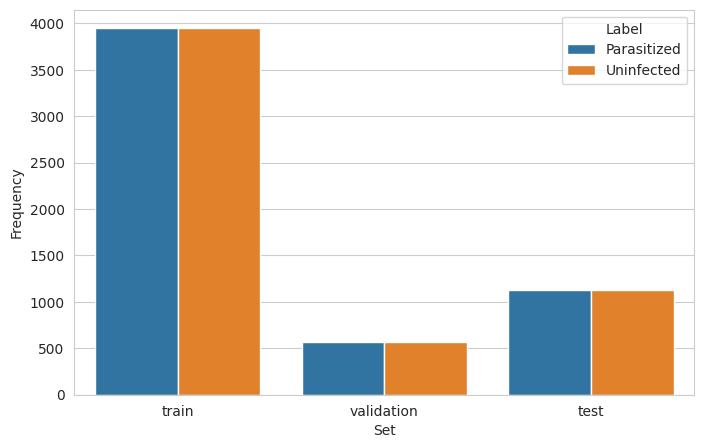

In [13]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


We can plot a bar graph to visualize the number of images and save this plot in our output directory for further use by running this code cell.

We don't have enough images to get effective results from deep learning - deep learning needs a LOT of images. Hence we need image augmentation.

---

# Image data augmentation

---

### ImageDataGenerator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# This function generates batches of image data with real-time data augmentation.

* ### Initialize ImageDataGenerator

In [15]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,  # zoom by 10%
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255  # between 0 and 255 pixels large
                                          )


* ### Augment training image dataset

In [16]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,  # flow_from_directory is a tensorflow function
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',  # only two classes of cell images
                                                     shuffle=True  # randomly shuffle
                                                     )

train_set.class_indices


Found 7900 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

You may be wondering why we’re not running similar image augmentation on our Test and validation datasets as we are on the training dataset. 

The reason for this is that we first need to build up our data set with large numbers of images of different scenarios so that we can train our model.

**REMEMBER it's Train, THEN validate and test.** 

We’ll then use the Test and Validation datasets to simply **test if our model is working.**

* ### Augment validation image dataset

In [17]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 1128 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment test image dataset

In [18]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 2258 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

## Plot augmented training image

(20, 129, 129, 3)


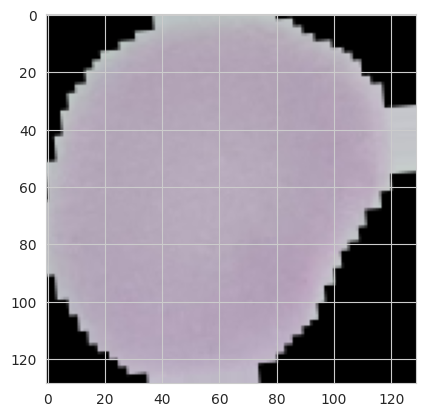

(20, 129, 129, 3)


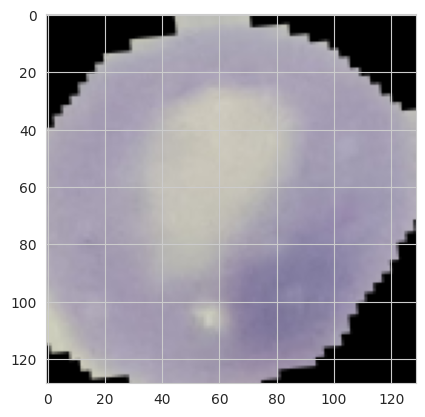

(20, 129, 129, 3)


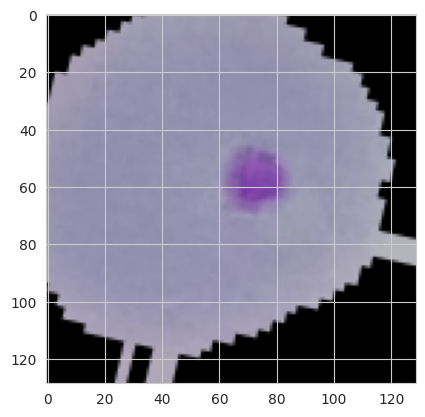

In [19]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(20, 129, 129, 3)


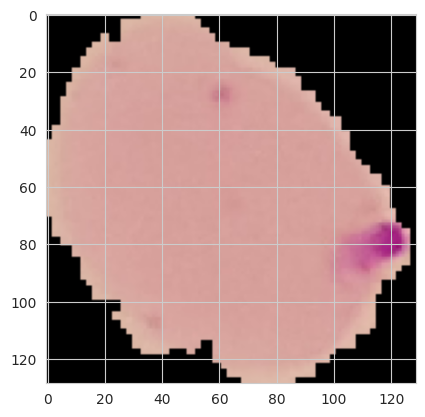

(20, 129, 129, 3)


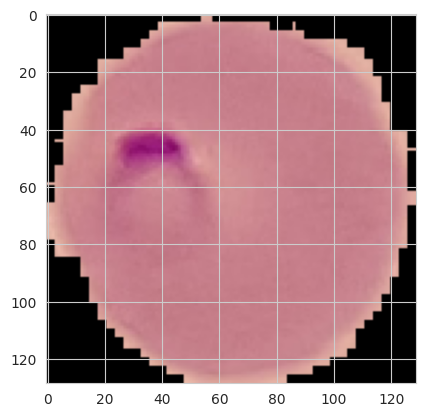

(20, 129, 129, 3)


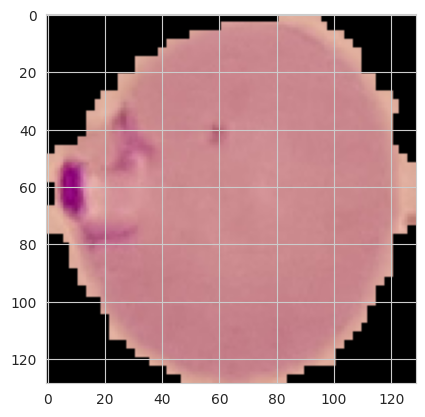

In [20]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


In [21]:
#  if you plot the augmented validation and test images
# we will see the images are not rotated or sheared but only the pixels have
# been standardized between 0 to 255 pixels. As you can see, the images are augmented and
# are ready to be used for developing and training a CNN model in the next video.

(20, 129, 129, 3)


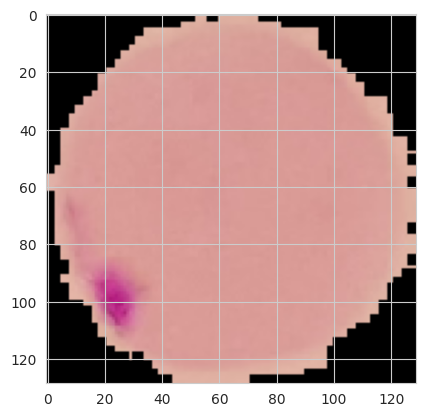

(20, 129, 129, 3)


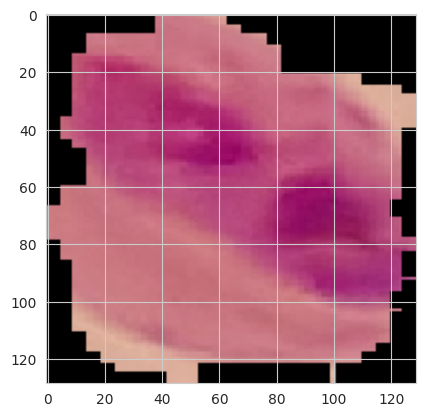

(20, 129, 129, 3)


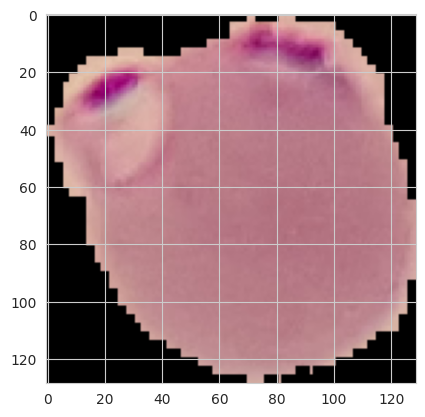

In [22]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [23]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

In [24]:
# The image augmentation process makes your model ready for the
# real-time implementation of the AI systems.
# It also increases our model performance while training, via increasing the number
# of different combinations of pattern images in the memory of the computer.
# Understanding Image augmentation helps in questions related to data augmentation
# and computer vision during a job interview.
# In this video, you saw augmented image data to train the model.


---

# Model creation

---

## ML model

* ### Import model packages

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [26]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),  # find only dominant pixels 
              input_shape=image_shape, activation='relu', ))   # uses average image shape from the data visualtion stage 
    model.add(MaxPooling2D(pool_size=(2, 2)))  # reduce size of image by extracting only those dominant features


    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # single list of all values, to feed into dense layer
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5)) # drop 50% to avoid overfitting 
    model.add(Dense(1, activation='sigmoid'))  # output layer (only 1 neuron) with probability result

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


* ### Model Summary 

In [27]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

2024-10-12 12:57:51.953819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Early Stopping 

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


Add early stopping to avoid any overfitting - to reduce diminishing returns

## Fit model for model training

This function triggers the learning process and iterates over the number of epochs
passed in the function. 

Here, we have used 25 epochs to train the model.

The validation data is used to find out the performance of the model while training and 
callbacks function to stop the model training in case of overfitting or underfitting of the model.

The verbose value controls the visualization of learning progress. 
Setting it to 0 hides the progress bar, 1 keeps its default, check-in the free time what happens with 2.

In [29]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


Epoch 1/25


2024-10-12 12:57:52.180519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  1/395 [..............................] - ETA: 6:18 - loss: 0.6827 - accuracy: 0.5000

395/395 [==============================] - 184s 463ms/step - loss: 0.5478 - accuracy: 0.7251 - val_loss: 0.2352 - val_accuracy: 0.9406
Epoch 2/25
395/395 [==============================] - 179s 454ms/step - loss: 0.3338 - accuracy: 0.8962 - val_loss: 0.1512 - val_accuracy: 0.9690
Epoch 3/25
395/395 [==============================] - 181s 458ms/step - loss: 0.1899 - accuracy: 0.9463 - val_loss: 0.1081 - val_accuracy: 0.9672
Epoch 4/25
395/395 [==============================] - 177s 449ms/step - loss: 0.1696 - accuracy: 0.9522 - val_loss: 0.1096 - val_accuracy: 0.9690
Epoch 5/25
395/395 [==============================] - 176s 445ms/step - loss: 0.1647 - accuracy: 0.9522 - val_loss: 0.1067 - val_accuracy: 0.9707
Epoch 6/25
395/395 [==============================] - 177s 449ms/step - loss: 0.1614 - accuracy: 0.9534 - val_loss: 0.1066 - val_accuracy: 0.9672
Epoch 7/25
395/395 [==============================] - 177s 447ms/step - loss: 0.1556 - accuracy: 0.9547 - val_loss: 0.1006 - val_accura

## Save model

In [30]:
model.save('outputs/v1/malaria_detector_model.h5')

---

# Model Performace

---

## Model learning curve

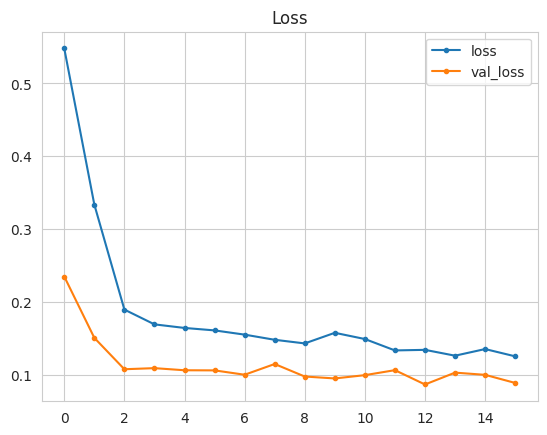

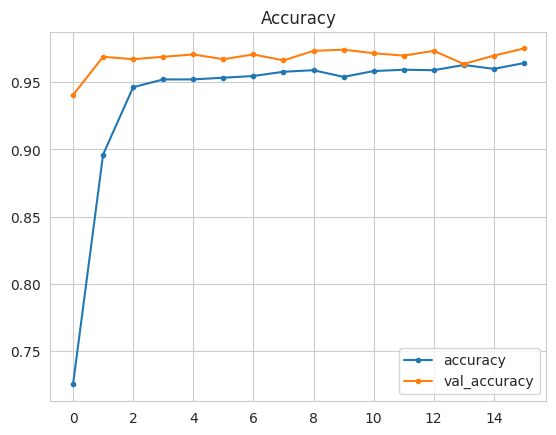

In [31]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [32]:
from keras.models import load_model
model = load_model('outputs/v1/malaria_detector_model.h5')

Evaluate model on test set

In [33]:
evaluation = model.evaluate(test_set)


113/113 [==============================] - 13s 117ms/step - loss: 0.1099 - accuracy: 0.9690


### Save evaluation pickle

In [34]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (129, 129), Image mode: RGB


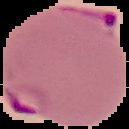

In [35]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [36]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 129, 129, 3)


Predict class probabilities

In [37]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.9999999999996905
Parasitized


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [38]:
!cat .gitignore

inputs/malaria_dataset/cell_images/test
inputs/malaria_dataset/cell_images/train
kaggle.json
*.ipynb
__pycache__/



* Git status

In [39]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   jupyter_notebooks/01 - DataCollection.ipynb
	modified:   jupyter_notebooks/02 - DataVisualization.ipynb
	new file:   outputs/v1/avg_diff.png
	new file:   outputs/v1/avg_var_Parasitized.png
	new file:   outputs/v1/avg_var_Uninfected.png
	new file:   outputs/v1/class_indices.pkl
	new file:   outputs/v1/image_shape.pkl

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/03 - Modelling and Evaluating.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	inputs/
	outputs/v1/evaluation.pkl
	outputs/v1/labels_distribution.png
	outputs/v1/malaria_detector_model.h5
	outputs/v1/model_training_acc.png
	outputs/v1/model_training_losses.png



* Git add

In [40]:
!git add .

* Git commit

In [41]:
!git commit -am " Add new plots"

[main 445da59c]  Add new plots
 1141 files changed, 990 insertions(+), 104 deletions(-)
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_135449_cell_136.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_141825_cell_133.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_142951_cell_143.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_142951_cell_146.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_142951_cell_150.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C130P91ThinF_IMG_20151004_142951_cell_151.png
 create mode 100644 inputs/malaria_dataset/cell_images/validation/Parasitized/C131P92ThinF_IMG_20151004_145224_cell_133.png
 create mode 100644 inputs/malaria_dataset/c

* Git Push

In [42]:
!git push

Enumerating objects: 1157, done.
Counting objects: 100% (1157/1157), done.
Delta compression using up to 32 threads
Compressing objects: 100% (1145/1145), done.
Writing objects: 100% (1152/1152), 32.95 MiB | 21.48 MiB/s, done.
Total 1152 (delta 2), reused 1130 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/RaymondBrien/WalkthroughProject01.git
   cabf7bb4..445da59c  main -> main


---